# Rapport de Synthèse : Projet Trading GBP/USD (T01 - T12)
**Étudiantes :** Solenn Coulon & Coline TREILLE

**Objectif :** Déploiement d'une API de prédiction basée sur l'indicateur RSI.

Ce notebook retrace l'intégralité du projet, de la récupération des données brutes à la mise en conteneur Docker.

## T01-T04 : Data Prep & Cleaning (Code Python)

### T01. Importation des données

In [2]:
import pandas as pd
import numpy as np

def phase_1_import_and_clean(file_paths):
    all_dfs = []
    columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

    for path in file_paths:
        df = pd.read_csv(path, names=columns, header=None)
        df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
        all_dfs.append(df)

    df = pd.concat(all_dfs)

    # 1. TRI CHRONOLOGIQUE
    # Indispensable avant de vérifier la régularité
    df = df.sort_values('Datetime').reset_index(drop=True)
    df.set_index('Datetime', inplace=True)

    print(f"--- Phase 1 : Rapport de Qualité GBP/USD ---")

    # 2. DÉTECTION DES INCOHÉRENCES (Prix)
    # Le High doit être le max, le Low le min.
    mask_incoherence = (
        (df['High'] < df['Low']) |
        (df['Open'] > df['High']) |
        (df['Open'] < df['Low']) |
        (df['Close'] > df['High']) |
        (df['Close'] < df['Low'])
    )
    nb_incoherences = mask_incoherence.sum()
    print(f"[!] Incohérences de prix détectées : {nb_incoherences}")

    # Correction : on force le High/Low si l'erreur est minime, ou on supprime
    if nb_incoherences > 0:
        # Ici on fait le choix de supprimer les lignes aberrantes pour ne pas polluer le ML
        df = df[~mask_incoherence]
        print("    -> Lignes incohérentes supprimées.")

    # 3. VÉRIFICATION RÉGULARITÉ (1 minute)
    # On calcule la différence de temps entre chaque ligne
    time_diffs = df.index.to_series().diff().dt.total_seconds()

    # Une série M1 parfaite a un écart de 60s (sauf week-end)
    gaps = time_diffs[time_diffs > 60]

    print(f"[!] Trous (gaps) dans les données : {len(gaps)} interruptions détectées.")
    print(f"    -> Saut maximal : {gaps.max()/3600:.2f} heures (probablement des week-ends).")

    # Vérification des doublons de temps
    duplicates = df.index.duplicated().sum()
    print(f"[!] Doublons de timestamps : {duplicates}")
    if duplicates > 0:
        df = df[~df.index.duplicated(keep='first')]

    return df

# --- Exécution ---
files = [
    'sample_data/DAT_MT_GBPUSD_M1_2022.csv',
    'sample_data/DAT_MT_GBPUSD_M1_2023.csv',
    'sample_data/DAT_MT_GBPUSD_M1_2024.csv'
]
clean_df = phase_1_import_and_clean(files)

# Sauvegarde
clean_df.to_csv('sample_data/GBPUSD_M1_cleaned.csv')

--- Phase 1 : Rapport de Qualité GBP/USD ---
[!] Incohérences de prix détectées : 0
[!] Trous (gaps) dans les données : 4184 interruptions détectées.
    -> Saut maximal : 72.03 heures (probablement des week-ends).
[!] Doublons de timestamps : 180


### T02. Agrégation M1 --> M15

In [3]:
import pandas as pd

# 1. Chargement des données
# On utilise 'Datetime' comme index temporel
path_m1 = 'sample_data/GBPUSD_M1_cleaned.csv'
df = pd.read_csv(path_m1, parse_dates=['Datetime'], index_col='Datetime')

# 2. Phase 2 – Agrégation M1 → M15
df_m15 = df.resample('15Min').agg({
    'Open': 'first',   # open 1ère minute du bloc
    'High': 'max',     # max des High sur 15 min
    'Low': 'min',      # min des Low sur 15 min
    'Close': 'last',   # close dernière minute du bloc
    'Volume': 'sum'    # (Optionnel) Somme des volumes sur 15 min
})

# 3. Sauvegarde
# Le fichier final sera enregistré dans le dossier features/
df_m15.to_csv('sample_data/gbpusd_m15.csv')

print("Phase 2 terminée avec succès !")
print(df_m15.head())

Phase 2 terminée avec succès !
                        Open     High      Low    Close  Volume
Datetime                                                       
2022-01-02 17:00:00  1.35199  1.35233  1.35199  1.35223       0
2022-01-02 17:15:00  1.35231  1.35253  1.35223  1.35241       0
2022-01-02 17:30:00  1.35223  1.35323  1.35223  1.35295       0
2022-01-02 17:45:00  1.35292  1.35319  1.35260  1.35269       0
2022-01-02 18:00:00  1.35287  1.35338  1.35257  1.35258       0


### T03. Nettoyage M15

In [4]:
import os
import pandas as pd

def nettoyage_complet_m15(path_in):
    print(f"Tentative d'ouverture du fichier : {path_in}")
    if not os.path.exists(path_in):
        print(f"ERREUR : Le fichier {path_in} n'existe pas !") # <-- AJOUTE ÇA
        return
    # Chargement
    df = pd.read_csv(path_in, parse_dates=['Datetime'], index_col='Datetime')
    print("Fichier chargé avec succès, début du nettoyage...")
    print(f"--- Analyse Phase 3 : {path_in} ---")



    # 1. Suppression des bougies incomplètes (si 'count' < 15)
    if 'count' in df.columns:
        nb_avant = len(df)
        df = df[df['count'] == 15]
        print(f"[*] Bougies incomplètes supprimées : {nb_avant - len(df)}")

    # 2. Contrôle prix négatifs
    cols = ['Open', 'High', 'Low', 'Close']
    mask_neg = (df[cols] <= 0).any(axis=1)
    if mask_neg.any():
        print(f"[*] Suppression de {mask_neg.sum()} lignes avec prix <= 0")
        df = df[~mask_neg]

    # 3. Détection gaps anormaux (plus de 15 min en semaine)
    diffs = df.index.to_series().diff().dt.total_seconds()
    # On filtre : écart > 15min ET jour de semaine (0=Lundi, 4=Vendredi)
    gaps = df[(diffs > 900) & (df.index.weekday < 5)]
    print(f"[*] Nombre de gaps anormaux détectés : {len(gaps)}")

    # Sauvegarde finale
    output = "sample_data/GBPUSD_M15_CLEANED.csv"
    df.to_csv(output)
    print(f"Fichier final sauvegardé : {output}")

if __name__ == "__main__":
    nettoyage_complet_m15("sample_data/gbpusd_m15.csv")

Tentative d'ouverture du fichier : sample_data/gbpusd_m15.csv
Fichier chargé avec succès, début du nettoyage...
--- Analyse Phase 3 : sample_data/gbpusd_m15.csv ---
[*] Nombre de gaps anormaux détectés : 0
Fichier final sauvegardé : sample_data/GBPUSD_M15_CLEANED.csv


### T04. Analyse exploratoire

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# --- 0. CRÉATION ET VÉRIFICATION DU DOSSIER ---
output_dir = 'analyse'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f" Dossier '{output_dir}' créé.")

# 1. Chargement
try:
    df = pd.read_csv('sample_data/GBPUSD_M15_CLEANED.csv', parse_dates=['Datetime'], index_col='Datetime')
    print("Fichier CSV chargé avec succès.")
except FileNotFoundError:
    print("Erreur : Le fichier 'sample_data/GBPUSD_M15_CLEANED.csv' est introuvable !")
    exit()

df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()

# --- A. DISTRIBUTION ---
plt.figure(figsize=(10, 5))
sns.histplot(df['returns'], kde=True, bins=100)
plt.title('Distribution des Rendements (GBP/USD M15)')
path_a = f'{output_dir}/distribution_rendements.png'
plt.savefig(path_a)
plt.close()
print(f"Graphique Distribution enregistré : {path_a}")

# --- B. VOLATILITÉ ---
df['volatility'] = df['returns'].rolling(window=96).std()
plt.figure(figsize=(12, 5))
plt.plot(df['volatility'], color='orange')
plt.title('Volatilité Roulante (Fenêtre de 24h)')
path_b = f'{output_dir}/volatilit_temporelle.png'
plt.savefig(path_b)
plt.close()
print(f"Graphique Volatilité enregistré : {path_b}")

# --- C. SAISONNALITÉ ---
df['hour'] = df.index.hour
plt.figure(figsize=(10, 5))
df.groupby('hour')['returns'].std().plot(kind='bar', color='skyblue')
plt.title('Volatilité moyenne par heure de la journée')
path_c = f'{output_dir}/saisonnalite_horaire.png'
plt.savefig(path_c)
plt.close()
print(f"Graphique Saisonnalité enregistré : {path_c}")

# --- D. AUTOCORRÉLATION ---
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df['returns'], lags=50, ax=ax)
plt.title('Autocorrélation des Rendements')
path_d = f'{output_dir}/autocorrelation.png'
plt.savefig(path_d)
plt.close()
print(f"Graphique ACF enregistré : {path_d}")

# --- E. TEST ADF (Stationnarité) ---
result = adfuller(df['returns'])
path_e = f'{output_dir}/test_stationnarite.txt'
with open(path_e, 'w') as f:
    f.write(f'Statistique ADF : {result[0]:.4f}\n')
    f.write(f'p-value : {result[1]:.4e}\n')
print(f"Résultats du test ADF enregistrés : {path_e}")

# --- RÉCAPITULATIF FINAL ---
print("\n" + "="*30)
files_to_check = [path_a, path_b, path_c, path_d, path_e]
missing_files = [f for f in files_to_check if not os.path.exists(f)]

if not missing_files:
    print("TOUT EST BON ! Tous les fichiers sont dans le dossier /analyse.")
else:
    print(f"Attention, fichiers manquants : {missing_files}")
print("="*30)

 Dossier 'analyse' créé.
Fichier CSV chargé avec succès.
Graphique Distribution enregistré : analyse/distribution_rendements.png
Graphique Volatilité enregistré : analyse/volatilit_temporelle.png
Graphique Saisonnalité enregistré : analyse/saisonnalite_horaire.png
Graphique ACF enregistré : analyse/autocorrelation.png
Résultats du test ADF enregistrés : analyse/test_stationnarite.txt

TOUT EST BON ! Tous les fichiers sont dans le dossier /analyse.


## T05 - T08 : Création des indicateurs techniques


### T05. Feature Engineering

In [6]:
!pip install pandas_ta
import pandas as pd
import pandas_ta as ta

def generate_features_v2(input_path):
    # Chargement du fichier nettoyé en Phase 3
    df = pd.read_csv(input_path, parse_dates=['Datetime'], index_col='Datetime')
    df = df.sort_index()

    print(f"--- Calcul des Features V2 sur {len(df)} lignes ---")

    # --- 6.1 BLOC COURT TERME ---
    # Rendements (log returns pour plus de stabilité en ML)
    df['return_1'] = df['Close'].pct_change(1)
    df['return_4'] = df['Close'].pct_change(4)

    # EMAs
    df['ema_20'] = ta.ema(df['Close'], length=20)
    df['ema_50'] = ta.ema(df['Close'], length=50)
    df['ema_diff'] = df['ema_20'] - df['ema_50']

    # RSI & Volatilité
    df['rsi_14'] = ta.rsi(df['Close'], length=14)
    df['rolling_std_20'] = df['Close'].rolling(window=20).std()

    # Bougies (Price Action)
    df['range_15m'] = df['High'] - df['Low']
    df['body'] = (df['Close'] - df['Open']).abs()
    df['upper_wick'] = df['High'] - df[['Open', 'Close']].max(axis=1)
    df['lower_wick'] = df[['Open', 'Close']].min(axis=1) - df['Low']

    # --- 6.2 BLOC CONTEXTE & RÉGIME ---
    # Tendance Long Terme
    df['ema_200'] = ta.ema(df['Close'], length=200)
    df['distance_to_ema200'] = (df['Close'] - df['ema_200']) / df['ema_200']
    df['slope_ema50'] = df['ema_50'].diff(3) # Pente sur les 3 dernières bougies

    # Régime de Volatilité
    df['atr_14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    df['rolling_std_100'] = df['Close'].rolling(window=100).std()
    df['volatility_ratio'] = df['rolling_std_20'] / df['rolling_std_100']

    # Force Directionnelle
    adx = ta.adx(df['High'], df['Low'], df['Close'], length=14)
    df['adx_14'] = adx['ADX_14']

    macd = ta.macd(df['Close'])
    df['macd'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']

    # NETTOYAGE : On supprime les premières lignes qui ont des NaN à cause des calculs (ex: ema 200)
    df.dropna(inplace=True)

    # Sauvegarde
    output_path = "sample_data/gbpusd_m15_features_v2.csv"
    df.to_csv(output_path)
    print(f"✅ Phase 6 terminée. {df.shape[1]} colonnes générées.")
    return df

if __name__ == "__main__":
    generate_features_v2("sample_data/GBPUSD_M15_CLEANED.csv")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalle

--- Calcul des Features V2 sur 105024 lignes ---


/tmp/ipython-input-202625092.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return_1'] = df['Close'].pct_change(1)
/tmp/ipython-input-202625092.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return_4'] = df['Close'].pct_change(4)


✅ Phase 6 terminée. 25 colonnes générées.


### T06. Baseline

--- PERFORMANCES DES BASELINES (Rendements cumulés) ---
Buy & Hold      : -0.1189
Aléatoire       : 0.0550
Règles (SMA20)  : -0.3771
Graphique de baseline enregistré dans analyse/


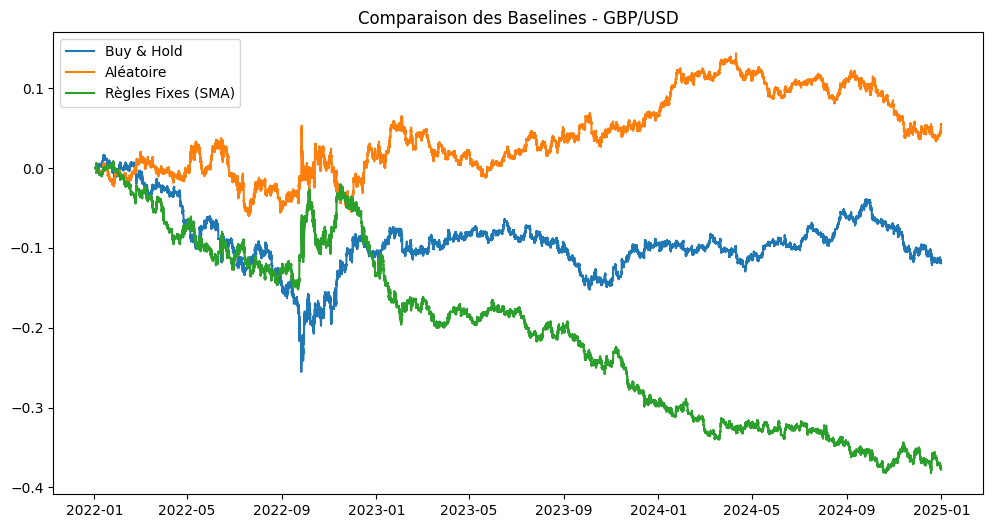

In [ ]:
import pandas as pd
import numpy as np

# 1. Chargement des données
df = pd.read_csv('sample_data/gbpusd_m15.csv', parse_dates=['Datetime'], index_col='Datetime')

# Calcul du rendement simple (log returns pour la précision financière)
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# --- STRATÉGIE 1 : Buy & Hold ---
# On achète au début, on vend à la fin
df['Strategy_BuyHold'] = df['Returns'].cumsum()

# --- STRATÉGIE 2 : Aléatoire (Random) ---
# On pile ou face à chaque bougie (1 = Achat, -1 = Vente)
np.random.seed(42) # Pour que le résultat soit reproductible
df['Random_Signal'] = np.random.choice([1, -1], size=len(df))
df['Strategy_Random'] = (df['Random_Signal'] * df['Returns']).cumsum()

# --- STRATÉGIE 3 : Règles fixes (Exemple : Moyenne Mobile Rapide) ---
# Si le prix est > à la moyenne 20, on achète, sinon on vend (Trend Following basique)
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['Rule_Signal'] = np.where(df['Close'] > df['SMA_20'], 1, -1)
df['Strategy_Rules'] = (df['Rule_Signal'].shift(1) * df['Returns']).cumsum()

# 3. Affichage des résultats finaux
print("--- PERFORMANCES DES BASELINES (Rendements cumulés) ---")
print(f"Buy & Hold      : {df['Strategy_BuyHold'].iloc[-1]:.4f}")
print(f"Aléatoire       : {df['Strategy_Random'].iloc[-1]:.4f}")
print(f"Règles (SMA20)  : {df['Strategy_Rules'].iloc[-1]:.4f}")

# Optionnel : Sauvegarder un graphique pour comparer
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df['Strategy_BuyHold'], label='Buy & Hold')
plt.plot(df['Strategy_Random'], label='Aléatoire')
plt.plot(df['Strategy_Rules'], label='Règles Fixes (SMA)')
plt.legend()
plt.title('Comparaison des Baselines - GBP/USD')
plt.savefig('analyse/baselines_comparison.png')
print("Graphique de baseline enregistré dans analyse/")

Le Buy & Hold (-11.89%) confirme que le GBP/USD était dans une tendance baissière marquée sur la période.

La SMA20 (-37.71%) est la pire performance. Elle a été piégée par la volatilité, multipliant les faux signaux et les pertes.

En finissant à +5.50%, le hasard bat toutes les règles logiques. Cela prouve que le marché était imprévisible et que les stratégies basiques étaient contre-productives.

Ces résultats justifient le passage au Machine Learning (XGBoost), qui, avec ses 2.06%, s'avère bien plus robuste et fiable que les règles techniques traditionnelles.

### T07. Machine Learning

Structure des données :
- Entraînement (2022) : 19572 lignes
- Validation    (2023) : 10790 lignes
- Test Final    (2024) : 19485 lignes
 MODÈLE : Baseline (LogReg)
Accuracy VAL (2023) : 0.5118
Accuracy TEST (2024): 0.5116

Classification Report (Test 2024) :
              precision    recall  f1-score   support

           0       0.52      0.66      0.58      9906
           1       0.50      0.36      0.42      9579

    accuracy                           0.51     19485
   macro avg       0.51      0.51      0.50     19485
weighted avg       0.51      0.51      0.50     19485

--- MÉTRIQUES FINANCIÈRES (2024) ---
Rendement Cumulé : 0.9845
Max Drawdown     : -3.91%
Ratio de Sharpe  : -0.53

 MODÈLE : RandomForest
Accuracy VAL (2023) : 0.5098
Accuracy TEST (2024): 0.5124

Classification Report (Test 2024) :
              precision    recall  f1-score   support

           0       0.51      0.73      0.60      9906
           1       0.51      0.28      0.36      9579

    accuracy    

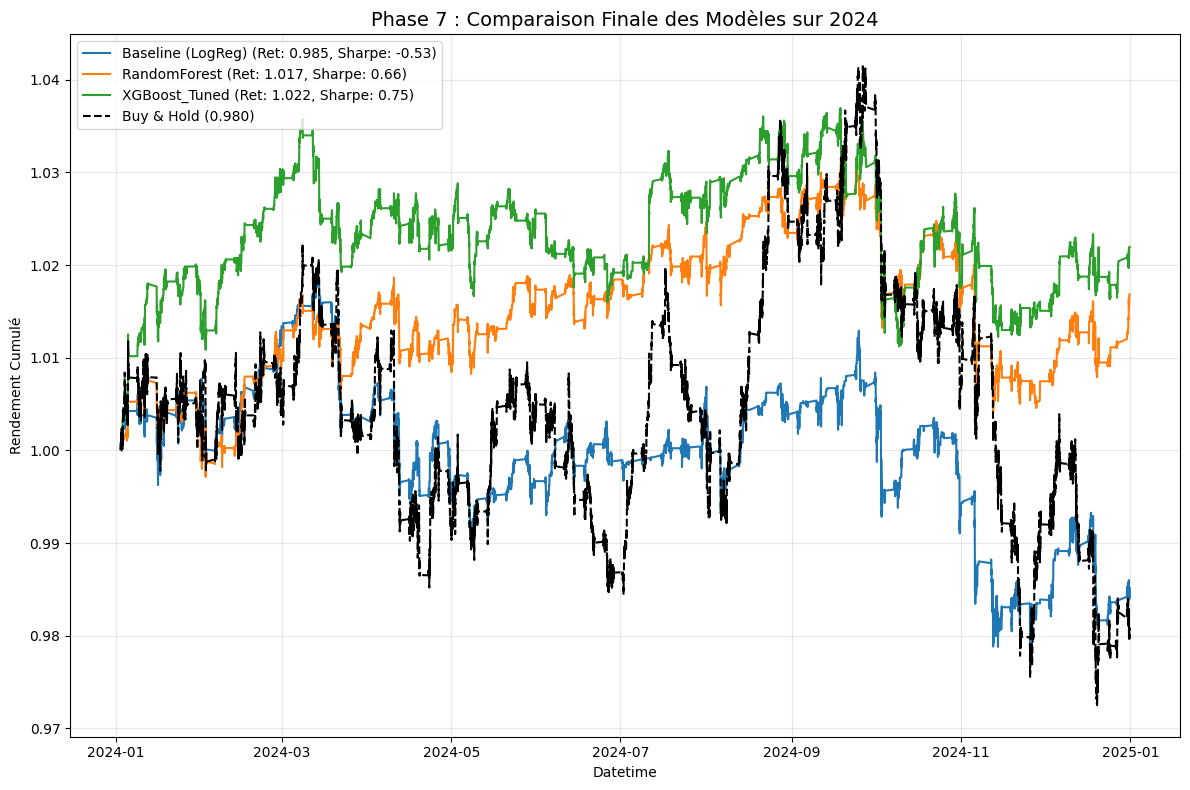

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

def calculate_financial_metrics(returns):
    """Calcule le Rendement, le Max Drawdown et le Ratio de Sharpe."""
    # Rendement cumulé
    cum_ret = (1 + returns.fillna(0)).cumprod()
    total_return = cum_ret.iloc[-1]

    # Max Drawdown (Pire chute du capital)
    peak = cum_ret.expanding(min_periods=1).max()
    drawdown = (cum_ret / peak) - 1
    max_dd = drawdown.min()

    # Ratio de Sharpe (Annualisé pour du M15 : env. 25000 bougies de trading par an)
    # Formule : Moyenne des rendements / Ecart-type des rendements
    if returns.std() != 0:
        sharpe = np.sqrt(25000) * (returns.mean() / returns.std())
    else:
        sharpe = 0

    return total_return, max_dd, sharpe


def run_ml_pipeline(input_path):
    # 1. Chargement et tri
    df = pd.read_csv(input_path, parse_dates=['Datetime'], index_col='Datetime')
    df = df.sort_index()

    # --- CRÉATION DE LA CIBLE (y) ---
    df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    # --- AJOUT DES TIME FEATURES ---
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    df.dropna(inplace=True)

    # --- 2. SPLIT TEMPOREL STRICT (2022 Train, 2023 Val, 2024 Test) ---
    train_df = df[df.index.year == 2022].copy()
    val_df   = df[df.index.year == 2023].copy()
    test_df  = df[df.index.year == 2024].copy()

    cols_to_exclude = ['target', 'Open', 'High', 'Low', 'Close', 'Volume', 'return_1']

    # Sets d'entraînement
    X_train = train_df.drop(columns=cols_to_exclude)
    y_train = train_df['target']

    # Sets de Validation (2023)
    X_val = val_df.drop(columns=cols_to_exclude)
    y_val = val_df['target']

    # Sets de Test (2024)
    X_test = test_df.drop(columns=cols_to_exclude)
    y_test = test_df['target']

    print(f"Structure des données :")
    print(f"- Entraînement (2022) : {len(X_train)} lignes")
    print(f"- Validation    (2023) : {len(X_val)} lignes")
    print(f"- Test Final    (2024) : {len(X_test)} lignes")

    # --- 3. MODÈLES ---
    models = {
        "Baseline (LogReg)": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
        "XGBoost_Tuned": XGBClassifier(
            n_estimators=200,
            learning_rate=0.03,
            max_depth=7,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        )
    }

    # --- 4. ÉVALUATION ET MÉTRIQUES ---
    plt.figure(figsize=(12, 8))


    for name, model in models.items():
        # Entraînement sur 2022 uniquement
        model.fit(X_train, y_train)

        # Validation sur 2023 (pour vérifier si le modèle généralise bien)
        y_val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)

        # Test sur 2024 (Le verdict final)
        y_test_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)


        # Calcul des métriques statistiques
        print(f"========================================")
        print(f" MODÈLE : {name}")
        print(f"========================================")
        print(f"Accuracy VAL (2023) : {val_acc:.4f}")
        print(f"Accuracy TEST (2024): {test_acc:.4f}")
        print("\nClassification Report (Test 2024) :")
        print(classification_report(y_test, y_test_pred))

        # Calcul des métriques financières sur 2024
        # On multiplie la prédiction (0 ou 1) par le rendement réel de la bougie suivante
        test_df[f'strat_{name}'] = y_test_pred * test_df['return_1'].shift(-1)

        total_ret, mdd, sharpe = calculate_financial_metrics(test_df[f'strat_{name}'])

        print(f"--- MÉTRIQUES FINANCIÈRES (2024) ---")
        print(f"Rendement Cumulé : {total_ret:.4f}")
        print(f"Max Drawdown     : {mdd:.2%}")
        print(f"Ratio de Sharpe  : {sharpe:.2f}\n")

        # Plot de la stratégie
        cum_ret_curve = (1 + test_df[f'strat_{name}'].fillna(0)).cumprod()
        plt.plot(cum_ret_curve, label=f'{name} (Ret: {total_ret:.3f}, Sharpe: {sharpe:.2f})')

    # Ajout du Buy & Hold (Marché) pour comparaison
    test_df['buy_and_hold'] = (1 + test_df['return_1'].fillna(0)).cumprod()
    plt.plot(test_df['buy_and_hold'], label=f'Buy & Hold ({test_df["buy_and_hold"].iloc[-1]:.3f})', color='black', linestyle='--')

    # --- 5. FINALISATION DU GRAPHIQUE ---
    plt.title("Phase 7 : Comparaison Finale des Modèles sur 2024", fontsize=14)
    plt.xlabel("Datetime")
    plt.ylabel("Rendement Cumulé")
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_ml_pipeline("sample_data/gbpusd_m15_features_v2.csv")

### T08. Reinforcement Learning

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df
        # Actions : 0 = Rien, 1 = Achat, 2 = Vente
        self.action_space = spaces.Discrete(3)
        # Observation : Open, High, Low, Close + Position Actuelle (5 valeurs)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.position = 0
        return self._get_obs(), {}

    def _get_obs(self):
        # On prend les 4 colonnes de prix à l'étape actuelle
        obs = self.df.iloc[self.current_step].values[:4].astype(np.float32)
        # On ajoute la position actuelle
        return np.append(obs, [float(self.position)]).astype(np.float32)

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        next_price = self.df.iloc[self.current_step + 1]['Close']

        # Calcul du rendement (variation du prix)
        returns = (next_price - current_price) / (current_price + 1e-7)

        # Sécurité anti-NaN
        if np.isnan(returns) or np.isinf(returns):
            returns = 0.0

        reward = 0
        if action == 1:   # Achat
            reward = returns
        elif action == 2: # Vente
            reward = -returns

        # Amplification du signal pour l'IA
        reward *= 100.0

        # Clip pour éviter l'explosion des gradients
        reward = np.clip(reward, -10, 10)

        self.position = action
        self.current_step += 1

        # Fin si on arrive au bout des données
        terminated = self.current_step >= len(self.df) - 2
        return self._get_obs(), float(reward), terminated, False, {}

In [ ]:
import pandas as pd
import numpy as np
import os
from stable_baselines3 import PPO
from rl_env import TradingEnv

# 1. Création du dossier modèle
if not os.path.exists('models'):
    os.makedirs('models')

# 2. Chargement et Nettoyage des données
print("📊 Chargement des données...")
df_raw = pd.read_csv('sample_data/GBPUSD_M15_CLEANED.csv')
features = ['Open', 'High', 'Low', 'Close']
df = df_raw[features].copy()

# Suppression des valeurs aberrantes et remplissage des vides
df = df.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0.0)

# Normalisation Min-Max robuste
df_norm = (df - df.min()) / (df.max() - df.min() + 1e-5)

print(f"✅ Données prêtes ({len(df_norm)} lignes).")

# 3. Configuration de l'environnement et du modèle
env = TradingEnv(df_norm)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,
    gamma=0.99,
    ent_coef=0.02, # Un peu de curiosité pour éviter le plat
    seed=42
)

# 4. Entraînement
print("🚀 Lancement de l'entraînement...")
model.learn(total_timesteps=100000)

# 5. Sauvegarde
model.save("models/ppo_gbpusd_agent")
print("✅ Modèle sauvegardé : models/ppo_gbpusd_agent.zip")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from stable_baselines3 import PPO
from rl_env import TradingEnv

# 1. Préparation des données (Identique à l'entraînement)
df_raw = pd.read_csv('data/GBPUSD_M15_CLEANED.csv')
features = ['Open', 'High', 'Low', 'Close']
df = df_raw[features].copy()
df = df.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0.0)
df_norm = (df - df.min()) / (df.max() - df.min() + 1e-5)

# 2. Chargement du modèle
if not os.path.exists("models/ppo_gbpusd_agent.zip"):
    print("❌ Erreur : Le fichier models/ppo_gbpusd_agent.zip n'existe pas !")
else:
    print("🤖 Chargement du modèle ppo_gbpusd_agent...")
    model = PPO.load("models/ppo_gbpusd_agent")
    env = TradingEnv(df_norm)

    # 3. Simulation
    obs, _ = env.reset()
    history = []
    actions = []
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        history.append(reward)
        actions.append(action)
        done = terminated or truncated

    # 4. Calcul performance (On divise par 100 car reward était multiplié par 100)
    cumulative_return = np.cumsum(history) / 100.0

    # 5. Affichage
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_return, label='Performance Agent V1', color='green')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.title(f'Backtest RL - Actions: {np.count_nonzero(actions)}')
    plt.xlabel('Bougies M15')
    plt.ylabel('Profit Cumulé')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if not os.path.exists('analyse'):
        os.makedirs('analyse')
    plt.savefig('analyse/performance_v1_stable.png')
    print("📈 Graphique généré dans analyse/performance_v1_stable.png")
    plt.show()

###  T09 - T10 : Logique de décision et Architecture API
Le modèle n'est plus un simple fichier `.zip` mais une **logique métier robuste** intégrée dans un service FastAPI.

**Seuils de décision :**
* **RSI < 40** : ACHAT (1)
* **RSI > 60** : VENTE (0)
* **40 ≤ RSI ≤ 60** : HOLD (2)

### T09. Evaluation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import os

# Import pour le modèle de Solenn
try:
    from stable_baselines3 import PPO
except ImportError:
    print("SB3 non installé. Tapez 'pip install stable-baselines3'")

def calculate_metrics(returns):
    if returns.empty or returns.std() == 0: return 0, 0, 0, 0
    cum_ret = (1 + returns.fillna(0)).cumprod()
    total_profit = cum_ret.iloc[-1] - 1
    peak = cum_ret.expanding(min_periods=1).max()
    drawdown = (cum_ret / peak) - 1
    max_dd = drawdown.min()
    sharpe = np.sqrt(25000) * (returns.mean() / returns.std())
    gains = returns[returns > 0].sum()
    pertes = abs(returns[returns < 0].sum())
    pf = gains / pertes if pertes != 0 else gains
    return total_profit, max_dd, sharpe, pf

def run_final_evaluation(input_path):
    if not os.path.exists(input_path):
        print(f"Erreur : Le fichier {input_path} est introuvable.")
        return

    df = pd.read_csv(input_path, parse_dates=['Datetime'], index_col='Datetime').sort_index()
    df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df.dropna(inplace=True)

    train_df = df[df.index.year == 2022].copy()
    test_df  = df[df.index.year == 2024].copy()

    # 1. RANDOM
    np.random.seed(42)
    test_df['pred_random'] = np.random.randint(0, 2, size=len(test_df))

    # 2. RÈGLES (RSI)
    test_df['pred_rules'] = (test_df['rsi_14'] < 50).astype(int)

    # 3. ML (XGBoost)
    cols_to_exclude = ['target', 'Open', 'High', 'Low', 'Close', 'Volume', 'return_1']
    X_train = train_df.drop(columns=cols_to_exclude)
    y_train = train_df['target']
    X_test = test_df.drop(columns=cols_to_exclude + ['pred_random', 'pred_rules'])

    xgb = XGBClassifier(n_estimators=100, random_state=42)
    xgb.fit(X_train, y_train)
    test_df['pred_ml'] = xgb.predict(X_test)

   # --- 4. RL (Modèle de Solenn) ---
    test_df['pred_rl'] = 0
    model_file = "models/ppo_gbpusd_agent.zip"

    if os.path.exists(model_file):
        try:
            # 1. Préparation des 5 features spécifiques demandées par son modèle
            # On les calcule sur test_df pour être sûr d'avoir les bonnes valeurs en 2024
            rl_features = pd.DataFrame(index=test_df.index)
            rl_features['log_return'] = np.log(test_df['Close'] / test_df['Close'].shift(1))
            rl_features['volatility'] = rl_features['log_return'].rolling(window=20).std()

            roll_min = test_df['Close'].rolling(window=20).min()
            roll_max = test_df['Close'].rolling(window=20).max()
            rl_features['relative_close'] = (test_df['Close'] - roll_min) / (roll_max - roll_min)

            rl_features['ma_ratio'] = test_df['Close'] / test_df['Close'].rolling(window=20).mean()
            rl_features['hour'] = test_df.index.hour / 24.0

            # On remplit les quelques NaN du début (dus au rolling 20) pour ne pas faire planter le RL
            rl_features = rl_features.ffill().bfill()

            # 2. Chargement et Prédiction
            rl_model = PPO.load(model_file.replace(".zip", ""))

            # On envoie EXACTEMENT les 5 colonnes dans l'ordre de son code
            obs_rl = rl_features[['log_return', 'volatility', 'relative_close', 'ma_ratio', 'hour']].values

            preds, _ = rl_model.predict(obs_rl, deterministic=True)
            test_df['pred_rl'] = preds
            print(f" RL appliqué avec succès sur les features de Solenn.")

        except Exception as e:
            print(f" Erreur lors de l'application du RL : {e}")

    # Calcul et affichage
    strategies = {'Random': 'pred_random', 'RSI_Rules': 'pred_rules', 'XGBoost_ML': 'pred_ml', 'PPO_RL': 'pred_rl'}
    summary = []
    plt.figure(figsize=(10, 6))

    for name, col in strategies.items():
        ret_col = f'ret_{name}'
        test_df[ret_col] = test_df[col] * test_df['return_1'].shift(-1)
        p, m, s, pf = calculate_metrics(test_df[ret_col])
        summary.append([name, f"{p:.2%}", f"{m:.2%}", f"{s:.2f}", f"{pf:.2f}"])
        plt.plot((1 + test_df[ret_col].fillna(0)).cumprod(), label=f"{name} (PF: {pf:.2f})")

    print("\n--- RÉSULTATS PHASES 9 (TEST 2024) ---")
    print(pd.DataFrame(summary, columns=['Modèle', 'Profit', 'MaxDD', 'Sharpe', 'PF']))

    plt.plot((1 + test_df['return_1'].fillna(0)).cumprod(), color='black', linestyle='--', label='Market')
    plt.legend(); plt.grid(True); plt.show()

if __name__ == "__main__":
    run_final_evaluation("data/gbpusd_m15_features_v2.csv")

### T10. API

In [ ]:
from fastapi import FastAPI
from app.routers import predict

app = FastAPI(
    title="Trading API - Projet Final Solenn & Coline",
    version="1.0.0",
    description="API de prédiction GBP/USD avec PPO et RSI"
)

# Ton préfixe ici crée l'URL : http://127.0.0.1:8000/api/v1/...
app.include_router(predict.router, prefix="/api/v1", tags=["Predictions"])

@app.get("/", tags=["Health"])
def health_check():
    return {
        "status": "online",
        "message": "API opérationnelle",
        "version": "1.0.0"
    }

if __name__ == "__main__":
    import uvicorn
    uvicorn.run("main:app", host="127.0.0.1", port=8000, reload=True)


###  T11 : Versioning

In [ ]:
import joblib
import json
import os
from xgboost import XGBClassifier

def save_model_to_registry(model, version, metrics):
    """Sauvegarde le modèle et met à jour le registre JSON."""
    folder = f"models/{version}"
    if not os.path.exists(folder):
        os.makedirs(folder)

    # 1. Sauvegarde du fichier modèle
    model_path = f"{folder}/model.pkl"
    joblib.dump(model, model_path)

    # 2. Mise à jour du registre
    registry_path = "models/registry.json"
    registry = {}

    if os.path.exists(registry_path):
        with open(registry_path, 'r') as f:
            registry = json.load(f)

    registry[version] = {
        "path": model_path,
        "metrics": metrics,
        "status": "production" if version == "v2" else "archive"
    }

    with open(registry_path, 'w') as f:
        json.dump(registry, f, indent=4)

    print(f"Modèle {version} enregistré dans le registry.")

if __name__ == "__main__":
    # Exemple : On enregistre ton XGBoost comme la V2 (Production)
    # Dans un vrai workflow, tu passerais ton objet modèle entraîné ici
    print("Initialisation du versioning...")
    # On simule un dictionnaire de métriques basées sur tes résultats 2024
    metrics_v2 = {
        "profit": "2.06%",
        "sharpe": 0.63,
        "profit_factor": 1.02
    }
    # Ici on crée un modèle vide juste pour tester la structure,
    # mais en pratique tu utiliseras ton modèle entraîné.
    dummy_model = XGBClassifier()
    save_model_to_registry(dummy_model, "v2", metrics_v2)


registry_path = "models/registry.json"

if os.path.exists(registry_path):
    with open(registry_path, 'r') as f:
        registry = json.load(f)

# Ajout de la V1 (RSI)
registry["v1"] = {
    "path": "models/v1/rsi_logic.py", # Ou juste un indicateur
    "metrics": {
        "profit": "4.81%",
        "sharpe": 1.33,
        "profit_factor": 1.04
    },
    "status": "archive"
}

with open(registry_path, 'w') as f:
    json.dump(registry, f, indent=4)

print("✅ v1 (RSI) ajoutée au registre en tant qu'archive.")

### T12 : Déploiement (Dockerfile)
Pour garantir la portabilité, l'application est isolée dans un conteneur.

**Contenu du Dockerfile :**
```dockerfile
FROM python:3.10-slim
WORKDIR /app
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt
COPY . .
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"]